In [1]:
import torch
import torch.nn as nn 
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
import numpy as np
from torchinfo import summary
from PIL import Image
import torch.nn.functional as F
from torchvision.datasets import FakeData # Test
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import math
import random

Size of data_coins 1000 : Size of labels_coins 1000
Size of data_others 1000 : Size of labels_others 1000


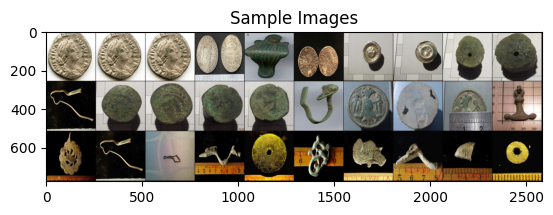

In [2]:
# Load data from external source
import os
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Docs:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataloader

# 256x256 images
path_to_coins = "/run/media/magnusjsc/T7/Classification-and-3D-reconstruction-of-archaeological-artifacts_DATA/resized_images_coin_256x256/"
path_to_others = "/run/media/magnusjsc/T7/Classification-and-3D-reconstruction-of-archaeological-artifacts_DATA/resized_images_others_256x256/"

def load_data_from_directory_with_limit(directory_path, label, limit=10000):
    data = []
    labels = []
    count = 0

    for filename in os.listdir(directory_path):
        if filename.endswith(".jpg"): 
            image_path = os.path.join(directory_path, filename)
            image = read_image(image_path)

            # Check if the image is RGB
            if image.shape[0] == 3:
                data.append(image)
                labels.append(label)
                count += 1

            if count >= limit:
                break

    return data, labels # Tuple

# Load data call
data_coins, labels_coins = load_data_from_directory_with_limit(path_to_coins, label=1, limit=1000)
data_others, labels_others = load_data_from_directory_with_limit(path_to_others, label=0, limit=1000)

print(f'Size of data_coins {len(data_coins)} : Size of labels_coins {len(labels_coins)}')
print(f'Size of data_others {len(data_others)} : Size of labels_others {len(labels_others)}')

def imshow_grid(images, num_images = 30):
    grid = torchvision.utils.make_grid(images[:num_images], nrow = 10)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title('Sample Images')
    plt.axis('on')
    plt.show()

num_images_to_display_per_category = 15
data_to_display = data_coins[:num_images_to_display_per_category] + data_others[:num_images_to_display_per_category]
imshow_grid(data_to_display, num_images=num_images_to_display_per_category * 2)

In [3]:
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision import transforms
from torchvision.io import read_image
import torch
import torchvision
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

class customDataset(Dataset):
    def __init__(self, tensors, transform=None):
        # Check the sizes of data and labels match
        assert all(tensors[0].size(0)==t.size(0) for t in tensors), "Size mismatch between tensors"

        # Assign input
        self.tensors = tensors
        self.transform = transform

    # What to do when we want an item from the dataset
    def __getitem__(self, index):
        # Return the transformed version of x if there are transforms
        if self.transform:
            x = self.transform(self.tensors[0][index])
        else: 
            x = self.tensors[0][index]

        # And return the label too
        y = self.tensors[1][index].view(1) # Convert y to a single-element tensor

        return x,y # Return the data as a tuple (data,label)

    def __len__(self):
        return self.tensors[0].size(0)


# Create a list of  transforms
imgTrans = transforms.Compose(
    [
        transforms.ToPILImage(), # PIL = library for images - Works for several transformations. To PIL image type
        transforms.RandomVerticalFlip(p=.5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor() # Transform the image to PyTorch tensor and normalizes the data [0;1] - Last 
    ]
)

# To Torch tensors
coin_dataT = torch.stack(data_coins)
coin_labelsT = torch.tensor(labels_coins)
other_dataT = torch.stack(data_others)
other_labelsT = torch.tensor(labels_others)

# For the Coin dataset
coin_data_transformed_defined = customDataset(tensors=(coin_dataT, coin_labelsT), transform=imgTrans)
# For the Other dataset
other_data_transformed_defined = customDataset(tensors=(other_dataT, other_labelsT), transform=imgTrans)
# Combine these two above datasets
combined_dataset_transformed_defined = ConcatDataset([coin_data_transformed_defined, other_data_transformed_defined])

# Split the data for training, validation, and testing
training = 0.7
validation = 0.15
testing = 0.15

total_size = len(combined_dataset_transformed_defined)
train_size = int(training * total_size)
val_size = int(validation * total_size)
test_size = total_size - train_size - val_size

# Randomly split the full dataset into training, validation and testing sets
train_set, val_set, test_set = random_split(combined_dataset_transformed_defined, [train_size, val_size, test_size])

# Hyperparameter - Batch size - GPU may be overloaded with memory allocations if too high
BATCH_SIZE = 50
# Create data loaders for each set
coin_loader = DataLoader(coin_data_transformed_defined, batch_size=BATCH_SIZE, shuffle=False) # For test -> below cell
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) # Shuffle the training set
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f'Total number of elements in train_loader: {len(train_loader) * BATCH_SIZE} : Each batch size {len(train_loader)}')
print(f'Total number of elements in val_loader: {len(val_loader) * BATCH_SIZE} : Each batch size {len(val_loader)}')
print(f'Total number of elements in test_loader: {len(test_loader) * BATCH_SIZE} : Each batch size {len(test_loader)}')

Total number of elements in train_loader: 1400 : Each batch size 28
Total number of elements in val_loader: 300 : Each batch size 6
Total number of elements in test_loader: 300 : Each batch size 6


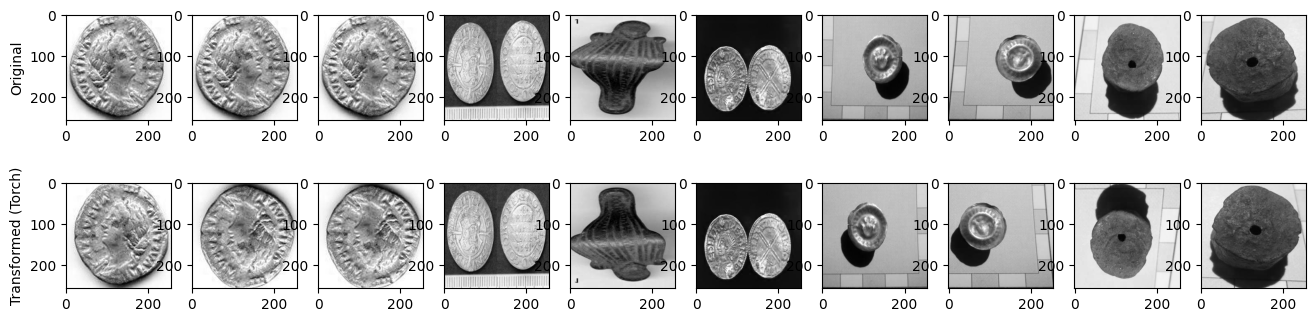

In [4]:
# Get a mini-batch from the train_loader and show differences before and after transformation
# Get the first 10 images from the train_loader
X, y = next(iter(coin_loader))

fig, axs = plt.subplots(2, 10, figsize=(16, 4))

# Loop over the first 10 images
for i in range(10):
    # Original images
    axs[0, i].imshow(coin_dataT[i, 0, :, :].detach().numpy(), cmap='gray')
    # Transformed images
    axs[1, i].imshow(X[i, 0, :, :].detach().numpy(), cmap='gray')

# Set labels
axs[0, 0].set_ylabel('Original')
axs[1, 0].set_ylabel('Transformed (Torch)')

plt.show()

In [5]:
toggle_print = False # Change to 'True' to print information of the model

# Hyperparameters 
d_model = 1024 # 16x16 number of patches times the number of channels - Before value: 768
n_heads = 8 # Multihead attention layer - Suggested = 8
dim_feedforward = 2048 # Dimension of the FFN layer - Before value: 4096
activation='gelu' # Activation function - For ViT the recommended activation functions is GeLU
batch_first = False # True = (batch, seq, feature), False = (Seq, batch, feature)
norm_first = True # Normalize before each encoder layer - Recommended = True
bias = True
dropout = 0.0 # Default = 0.1
layer_norm = nn.LayerNorm(d_model)
n_classes = 1 # either 0 or 1. Do not change!
n_layers = 8 # Encoder (simular) sub-layers - Suggested = 8
n_image_channels = 3 # RGB 
max_n_patches = 256 # 16x16
patch_size = 16 # -> 16x16 - Try with 32
n_hidden = 2 # FFN hidden layers - 2 
learning_rate = 0.1 # Default = 0.01
weight_decay = 0.9 # 0.999 is also proposed

# Using the convolution kernel for ease of implementation and patch embeddings - First step
# Using a Conv2d layer for linear projection it becomes a hybrid model
class PatchEmbeddings(nn.Module):
    def __init__(
        self,
        d_model: int, 
        patch_size: int, 
        in_channels: int 
    ):
        super().__init__()

        # Sliding window approach - Size(Kernel)=Size(Stride)
        self.conv = nn.Conv2d(
            in_channels = in_channels, # 3 channel: RGB
            out_channels = d_model, # 256 * 3 -> Each patch becomes one 'pixel' and will have 3 values in embedding space i.e. 768 d_model
            kernel_size = patch_size, 
            stride = patch_size,
            bias = bias
        )

    def forward(self, x: torch.Tensor):
        x = self.conv(x)
        bs, c, h, w = x.shape
        print(f'Shape of x after convolution: {x.shape}') if toggle_print else None
        x = x.permute(2, 3, 0, 1)
        x = x.view(h * w, bs ,c)
        print(f'Shape of x after convolution and permutation: {x.shape}') if toggle_print else None
        return x
        

# Relative positional Encoding - Second step
class PositionalEmbedding(nn.Module): 
    def __init__(
        self, 
        d_model: int, 
        max_len: int = 256 # 256 = default. Number of maximum patches - 256 = 16x16 patches 
    ):
        super().__init__()

        self.positional_encodings = nn.Parameter(
            torch.zeros(
                max_len, 
                1, 
                d_model
            ), 
            requires_grad = True)

    def forward(self, x: torch.Tensor):
        # pe = tensor of length 256 to match input size of x, d_model is still preserved and added to x
        pe = self.positional_encodings[:x.shape[0]]
        return x + pe

# The classification step (last step)
class ClassificationHead(nn.Module):
    def __init__(
        self, 
        d_model: int, 
        n_hidden: int, 
        n_classes: int
    ):
        super().__init__()

        self.linear1 = nn.Linear(
            in_features = d_model, 
            out_features = n_hidden,
            bias = True
        ) 
        
        self.act = nn.Tanh() 
        
        self.linear2 = nn.Linear(
            in_features = n_hidden, 
            out_features = n_classes,
            bias = True
        ) # Last - Predicts

        # Squash predictions between 0 and 1 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        x = self.linear1(x)
        x = self.act(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        
        return x

# Our transformer model i.e. contains the encoder - middle step
class VisionTransformer(nn.Module):
    def __init__(
        self, 
        n_layers: int, # Number of transformer layers
        patch_emb: PatchEmbeddings, # patch embedding layers
        pos_emb: PositionalEmbedding,  # PE 
        classification: ClassificationHead # Classification head
    ):
        super().__init__()

        self.patch_emb = patch_emb # x is passed to patch_emb
        self.pos_emb = pos_emb # x is passed to pos_emb
        self.classification = classification

        self.transformer_encoder_layer = nn.TransformerEncoderLayer( # https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html
            d_model = d_model,
            nhead = n_heads,
            dim_feedforward = dim_feedforward,
            dropout = dropout,
            activation = activation, # GeLU is recommended
            batch_first = batch_first,
            norm_first = norm_first,
            bias = bias
        )
        self.transformer_encoder = nn.TransformerEncoder( # https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html
            encoder_layer = self.transformer_encoder_layer,
            num_layers = n_layers, # n times encoder layers (above)
            norm = layer_norm,
            enable_nested_tensor = False
        )
        
        # Init class tokens for each batch element of input x - NOTE: Might produce values like: 6.1806e-01 which is equivalent to 0.618060 in scientific notation 
        self.class_tokens = nn.Parameter(
            torch.rand(
                (1, 1, d_model), 
                requires_grad = True),
                    
        ) # Learnable class token for each element in batch

        self.ln = nn.LayerNorm([d_model])
        
        print(f'Class token: {self.class_tokens}') if toggle_print else None
        print(f'Shape of class token: {self.class_tokens.shape}') if toggle_print else None
        
        
    def forward(self, x: torch.Tensor):

        x = self.patch_emb(x)

        class_tokens = self.class_tokens.expand(-1, x.shape[1], -1)
        x = torch.cat([class_tokens, x])

        print(f'Class token values after class token is added: {x[0]}') if toggle_print else None

        x = self.pos_emb(x)

        print(f'Class token value after pos_emb: {x[0]}') if toggle_print else None
        print(f'Shape of x after pos_emb: {x.shape}') if toggle_print else None

        x = self.transformer_encoder(x)

        print(f'Shape of x after transformer {x.shape}') if toggle_print else None

        x = x[0] # Get class token

        print(f'x[0] value {x}') if toggle_print else None

        x = self.ln(x)

        x = self.classification(x)

        print(f'Classification of x value: {x}') if toggle_print else None
        
        return x

# Model
vit_model = VisionTransformer(
    n_layers = n_layers, 
    patch_emb = PatchEmbeddings( # Patch emb
        d_model = d_model, 
        patch_size = patch_size, 
        in_channels = n_image_channels
    ), 
    pos_emb = PositionalEmbedding( # Positional encoding
        d_model = d_model,
        max_len = max_n_patches + 1
    ), 
    classification = ClassificationHead( # Classification head 
        d_model = d_model, 
        n_hidden = n_hidden, 
        n_classes = n_classes
    )
)

# Loss function
loss_func = nn.BCEWithLogitsLoss() # BCE=−1/n​∑i=1​(y_i​log(yHat_​i​)+(1−y_i​)log(1−yHat_i​))

# Optimizer 
optimizer = Adam(
    vit_model.parameters(), 
    lr = learning_rate,
    weight_decay = weight_decay
)

# Summary of the model - https://pypi.org/project/torchinfo/
summary(
    model = vit_model,
    input_size = (
        BATCH_SIZE, 3, 256, 256),  # c, h, w
    verbose = 1,  # 2 for full info
    col_names = [
        "input_size", 
        "num_params", 
        "output_size", 
        "mult_adds", 
        "trainable"
    ],
    mode = "train"
)

Layer (type:depth-idx)                        Input Shape               Param #                   Output Shape              Mult-Adds                 Trainable
VisionTransformer                             [50, 3, 256, 256]         8,400,896                 [50, 1]                   --                        True
├─PatchEmbeddings: 1-1                        [50, 3, 256, 256]         --                        [256, 50, 1024]           --                        True
│    └─Conv2d: 2-1                            [50, 3, 256, 256]         787,456                   [50, 1024, 16, 16]        10,079,436,800            True
├─PositionalEmbedding: 1-2                    [257, 50, 1024]           263,168                   [257, 50, 1024]           --                        True
├─TransformerEncoder: 1-3                     [257, 50, 1024]           --                        [257, 50, 1024]           --                        True
│    └─ModuleList: 2-2                        --                 

Layer (type:depth-idx)                        Input Shape               Param #                   Output Shape              Mult-Adds                 Trainable
VisionTransformer                             [50, 3, 256, 256]         8,400,896                 [50, 1]                   --                        True
├─PatchEmbeddings: 1-1                        [50, 3, 256, 256]         --                        [256, 50, 1024]           --                        True
│    └─Conv2d: 2-1                            [50, 3, 256, 256]         787,456                   [50, 1024, 16, 16]        10,079,436,800            True
├─PositionalEmbedding: 1-2                    [257, 50, 1024]           263,168                   [257, 50, 1024]           --                        True
├─TransformerEncoder: 1-3                     [257, 50, 1024]           --                        [257, 50, 1024]           --                        True
│    └─ModuleList: 2-2                        --                 

In [6]:
# Train the model on a minibatch for testing
from torch.optim import Adam
import torch
import gc
# Metrics library
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Hyperparameters
num_epochs = 5
threshold = 0.5

# Lists to store metrics for each epoch
train_losses = []
val_losses = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

if cuda_available:
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"CUDA is available. Number of GPUs: {num_gpus}")
    vit_model = vit_model.cuda()
else:
    print("CUDA is not available. Using CPU.")

def validate(model, loss_func, val_loader):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for i, data in enumerate(val_loader, start = 0):
            inputs, target = data
            # Move input data to GPU if CUDA is available
            if cuda_available:
                inputs, target = inputs.cuda(), target.cuda()
                
            output = model(inputs)
            predictions = output # Predictions of x
            loss = loss_func(predictions, target.float())
            total_loss += loss.item() 
            
            preds = torch.sigmoid(predictions) > threshold # Threshold is used to determine the predicted value - 0 or 1 based on threshold value
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # https://scikit-learn.org/stable/modules/model_evaluation.html
    avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(
        all_targets, 
        all_preds
    )
    precision = precision_score(
        all_targets, 
        all_preds, 
        zero_division = 0,
        average = 'binary'
    )
    recall = recall_score(
        all_targets, 
        all_preds
    )
    f1 = f1_score(
        all_targets, 
        all_preds)

    return avg_loss, accuracy, precision, recall, f1

# Training loop
def train(
    model, 
    loss_func, 
    optimizer, 
    train_loader,
    val_loader, 
    # test_loader,
    num_epochs = num_epochs,
):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        # Iterate over dataset
        for i, data in enumerate(train_loader, start = 0):
            inputs, target = data # target shape: [BATCH_SIZE,1]
            
            # Move input data to GPU if CUDA is available
            if cuda_available:
                input_data, target = inputs.cuda(), target.cuda()
            
            optimizer.zero_grad() # Instanitate optimizer
            output = model(input_data)
            predictions = output # Predicition of x
            
            loss = loss_func(predictions, target.float())
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)

        # Validation call
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate(
            model = vit_model,
            loss_func = loss_func, 
            val_loader = val_loader
        )

        # Append metrics to lists
        train_losses.append(avg_loss)
        val_losses.append(val_loss)
        accuracies.append(val_accuracy)
        precisions.append(val_precision)
        recalls.append(val_recall)
        f1_scores.append(val_f1)

        # Print training and validation metrics
        print(f'Epoch {epoch + 1}/{num_epochs} - '
              f'Training Loss: {avg_loss:.4f} - '
              f'Validation Loss: {val_loss:.4f} - '
              f'Validation Accuracy: {val_accuracy:.4f} - '
              f'Validation Precision: {val_precision:.4f} - '
              f'Validation Recall: {val_recall:.4f} - '
              f'Validation F1 Score: {val_f1:.4f}')

        # Clear GPU memory after each epoch
        torch.cuda.empty_cache()
        gc.collect()


    # Plotting
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(10, 6))
    
    # Plot Training and Validation Losses
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy, Precision, Recall, and F1 Score
    plt.subplot(2, 1, 2)
    plt.plot(epochs, accuracies, label='Accuracy')
    plt.plot(epochs, precisions, label='Precision')
    plt.plot(epochs, recalls, label='Recall')
    plt.plot(epochs, f1_scores, label='F1 Score')
    plt.title('Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    ''' TODO:
    # Testing call 
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = test(
        model = vit_model,
        loss_func = loss_func, 
        test_loader = test_loader
    )
    '''
    
# Training, validation and testing init
train(
    model = vit_model, 
    loss_func = loss_func, 
    optimizer = optimizer, 
    num_epochs = num_epochs,
    train_loader = train_loader,
    val_loader = val_loader
)

CUDA is available. Number of GPUs: 1


OutOfMemoryError: CUDA out of memory. Tried to allocate 152.00 MiB. GPU 0 has a total capacty of 5.79 GiB of which 110.44 MiB is free. Including non-PyTorch memory, this process has 5.09 GiB memory in use. Of the allocated memory 4.89 GiB is allocated by PyTorch, and 90.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [7]:
# Grid search for hyperparameter tuning 

from sklearn.model_selection import GridSearchCV # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.base import BaseEstimator, ClassifierMixin

param_grid = {
    # Add hyperparameters here
    'lr': [0.001, 0.01, 0.1],
    'batch_size': [16,32,64],
    'd_model': [768, 1024],
    'dim_feedforward': [2048, 4096],
    'activation': ['gelu','relu'],
    'batch_first': [True, False],
    'norm_first': [True, False],
    'dropout': [0.0, 0.1],
    'n_layers': [6, 8],
    'patch_size': [16,32],
    'learning_rate': [0.01, 0.1],
    'weight_decay': [0.9, 0.999]
}

class VisionTransformerClassifier(BaseEstimator, ClassificationHead):
    def __init__(self, **kwargs):
        # Model 
        # Loss func
        # Optimizer

    def fit(self, X, y):
        # Training logic
        return self

    def predict(self, X):
        # Prediciton logic
        return predictions 

# Instance of a compatiable classifier for scikit-learn
vit_classifier = VisionTransformerClassifier() 

grid_search = GridSearchCV(
    estimator = vit_model,
    param_grid = param_grid,
    scoring = 'accuracy',
    cv = 3,
    n_jobs = 1, # -1 = use all processors, 1 = use one 
    verbose = 3, # Show all information 
)

# Get hold of the data to train the model
X, y = train_loader
print(f'X, y {X.shape} : {y.shape}')

grid_search.fit(X, y)

# Get best hyperparameters and best model
best_hyperparameters = grid_search.best_params_
best_model = grid_search.best_model

# Evaluate the best model on the validation set
val_predictions = best_model.predict(val_loader)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy with Best Model: {val_accuracy * 100:.2f}%")

print("Best Hyperparameters: ", best_hyperparameters)
print("Best Model: ", best_model)

ValueError: too many values to unpack (expected 2)